In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow

In [2]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, Concatenate, Lambda, Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, MaxPool2D, UpSampling2D, ZeroPadding2D, Add, Convolution2D, concatenate, GlobalAveragePooling2D, Input
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import VGG16, ResNet101

from keras.optimizers import SGD

In [3]:
import scipy.io
from skimage.transform import resize
import numpy as np
import math

In [4]:
mat = scipy.io.loadmat('oct-segmentation/2015_BOE_Chiu/Subject_01.mat')

In [5]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Mar 07 12:12:16 2015',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]],
 
        [[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 2

In [6]:
X_tt = np.transpose(mat['images'],(2,0,1))
y_tt = np.transpose(mat['manualFluid1'],(2,0,1))

In [7]:
X_tt[0].shape

(496, 768)

In [8]:
X_tt.shape, y_tt.shape

((61, 496, 768), (61, 496, 768))

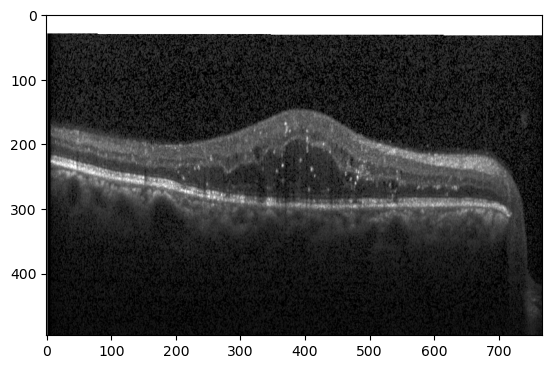

In [9]:
plt.imshow(X_tt[35],cmap='gray')

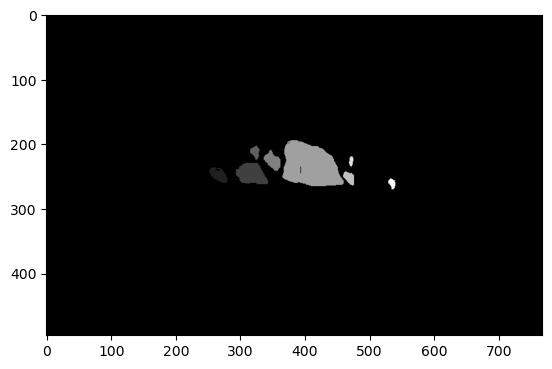

In [10]:
plt.imshow(y_tt[35],cmap='gray')

In [11]:
type(X_tt[35]), X_tt[35].shape

(numpy.ndarray, (496, 768))

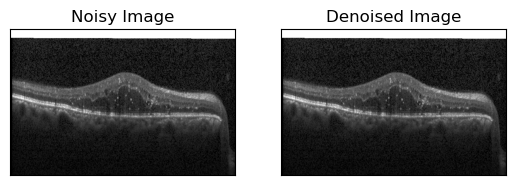

In [12]:
#FFT 

# Read the noisy image
noisy_img = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)
noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2GRAY)

# Perform FFT
f = np.fft.fft2(noisy_img)
f_shift = np.fft.fftshift(f)

# Apply Gaussian filter to remove high-frequency noise
#rows, cols = noisy_img.shape
#crow, ccol = rows // 2, cols // 2
#f_shift[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0

# Perform inverse FFT
f_ishift = np.fft.ifftshift(f_shift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display original and denoised images
plt.subplot(121), plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Denoised Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#Increasing contrast using histogram equalization

# Read the image
image = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(gray_image)

# Convert the equalized image back to BGR format
equalized_image_bgr = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

# Display the original and equalized images
cv2.imshow('Original Image', image)
cv2.imshow('Equalized Image', equalized_image_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Read the noisy image
noisy_image = cv2.cvtColor(X_tt[35], cv2.COLOR_RGB2BGR)
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to remove noise
denoised_image = cv2.GaussianBlur(noisy_image, (5, 5), 0)  # Adjust the kernel size as needed

# Display the original and denoised images
cv2.imshow('Noisy Image', noisy_image)
cv2.imshow('Denoised Image', denoised_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
paths = ['oct-segmentation/2015_BOE_Chiu/Subject_0{}.mat'.format(i) for i in range(1,10)]+['oct-segmentation/2015_BOE_Chiu/Subject_10.mat']

In [14]:
def thresh(x):
    if x>0.5:
        return 1
    else:
        return 0

thresh = np.vectorize(thresh, otypes=[np.float32]) #apply thresh function pixel-wise to the img inp

In [15]:
def visualize(paths):
    new_X, new_Y= [],[]
    for path in paths:
        mat = scipy.io.loadmat(path)
        
        X = np.transpose(mat['images'],(2,0,1))
        Y = np.transpose(mat['manualFluid1'],(2,0,1))
        
        new_X.append(X[:11])
        new_X.append(X[11:22])
        new_X.append(X[22:33])
        new_X.append(X[33:44])
        new_X.append(X[44:55])
        new_X.append(X[55:62])
        
        new_Y.append(Y[:11])
        new_Y.append(Y[11:22])
        new_Y.append(Y[22:33])
        new_Y.append(Y[33:44])
        new_Y.append(Y[44:55])
        new_Y.append(Y[55:61])
        #Y = thresh(Y)
        #print(Y)
        
        print(X.shape,Y.shape)
        
        # prediction visualization
        for i in range(len(new_X)):
            print(i)
            nrows = 11
            fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 10))
            for j in range(nrows):
                axes[j][0].imshow(np.reshape(new_X[i][j], (496, 768)))
                axes[j][1].imshow(np.reshape(new_Y[i][j], (496, 768)))
            plt.show()

In [ ]:
visualize(paths[5:6])

In [16]:
X, y = [],[]

def preprocess(path,data_indexes):
    x, y, new_imgs = [],[], []
    
    mat = scipy.io.loadmat(path)
      
    imgs = np.transpose(mat['images'],(2,0,1))
    plt.subplot(121), plt.imshow(imgs[35])
    for i in range(imgs.shape[0]):
        img = filter_image(imgs[i])
        img = img/255
        new_imgs.append(img)
    new_imgs = np.array(new_imgs)
    print(new_imgs.shape[0])
    imgs = resize(new_imgs,(new_imgs.shape[0],224,224))
    plt.subplot(122), plt.imshow(imgs[35])
        
    fluids = np.transpose(mat['manualFluid1'],(2,0,1))
    fluids = thresh(fluids)
    #plt.subplot(123), plt.imshow(fluids[35],cmap='gray')
    fluids = resize(fluids, (fluids.shape[0],224,224))
        
    for i in data_indexes:
        x += [np.expand_dims(imgs[i],axis=2)]
        y += [np.expand_dims(fluids[i],axis=2)]
    
    return np.array(x), np.array(y)

In [18]:
def filter_image(img,clip_limit=7, grid_size=12, filter_h=15, filter_window=7, search_window=25):
    filtered_img = cv2.fastNlMeansDenoising(img, h=filter_h, templateWindowSize=filter_window, searchWindowSize=search_window)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    clahe_image = clahe.apply(filtered_img)
    
    return clahe_image

61


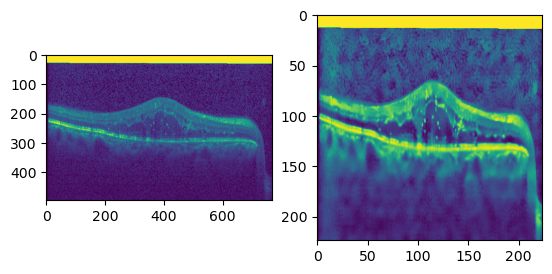

In [19]:
x_ttt, y_ttt = preprocess(paths[0],[10,15,20,25,28,30,32,35,40,45,50])

61
11
61
11
61
11
61
11
61
11
61
11
61
11
61
11
61
11
61
11


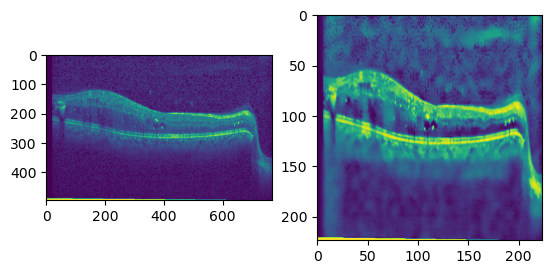

In [20]:
for i in range(len(paths)):
    data_indexes = [[10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [6,11,16,21,24,26,28,31,36,41,46],
                    [8,13,18,23,26,28,30,33,38,43,48],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [11,16,21,26,29,31,33,36,41,46,51],
                    [8,13,18,23,26,28,30,33,38,43,48],
                    [10,15,20,25,28,30,32,35,40,45,50],
                    [10,15,20,25,28,30,32,35,40,45,50]]
    X_t,y_t = preprocess(paths[i],data_indexes[i])
    print(len(X_t))
    for i in range(len(X_t)):
        X.append(X_t[i])
        y.append(y_t[i])

In [21]:
X = np.array(X)
y = np.array(y)

In [22]:
X.shape, y.shape

((110, 224, 224, 1), (110, 224, 224, 1))

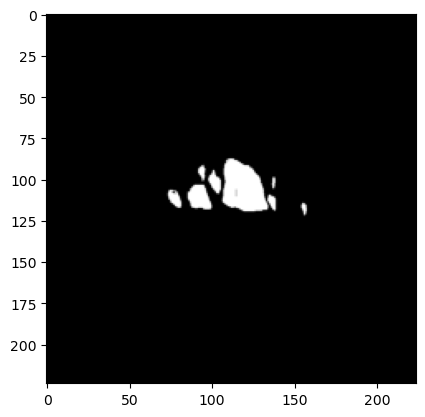

In [23]:
plt.imshow(y[7],cmap='gray')

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99, 224, 224, 1), (11, 224, 224, 1), (99, 224, 224, 1), (11, 224, 224, 1))

In [26]:
set(y_test.flatten())

{0.0,
 3.7289846e-07,
 5.515554e-05,
 0.0001148132,
 2.4303647e-05,
 0.06822061,
 0.14200978,
 0.0004612294,
 2.656842e-07,
 0.00032408928,
 0.0005835417,
 0.17857058,
 0.3992603,
 0.0023722572,
 0.0012066253,
 0.051931042,
 0.013677824,
 0.022886623,
 0.48399258,
 0.013576377,
 0.022659648,
 0.9988757,
 0.9999364,
 0.06921945,
 0.43060994,
 0.0009611975,
 0.00026691885,
 0.0008131656,
 0.00927325,
 0.04792847,
 0.0039152987,
 0.70644677,
 0.8960525,
 0.31301415,
 0.968055,
 0.027498666,
 0.061384123,
 0.009243991,
 0.9751372,
 0.9999269,
 0.8891902,
 0.9942342,
 0.4396726,
 0.81424916,
 0.87085927,
 0.45673573,
 0.4997388,
 0.27882588,
 0.9185811,
 0.6551,
 0.86594,
 6.881562e-05,
 0.64923674,
 0.8870297,
 0.29448146,
 0.0004076408,
 0.00025940777,
 0.0027062944,
 0.11399307,
 0.808932,
 0.39169568,
 0.00022204452,
 0.41318622,
 0.37512317,
 0.0051423814,
 0.023842981,
 0.9986755,
 0.00804792,
 0.09719262,
 0.031271193,
 0.009279642,
 0.36494166,
 0.26621383,
 0.8675017,
 0.6525569,
 

In [27]:
# U-Net
inp = Input(shape=(224,224,1))

#Contraction path
c1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(inp)
c1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(c1)
p1 = MaxPool2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p1)
c2 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c2)
p2 = MaxPool2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p2)
c3 = Conv2D(256, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = MaxPool2D((2,2))(c3)

c4 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(p3)
c4 = Conv2D(512, (3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c4)

#Bottleneck layer
p4 = MaxPool2D((2,2))(c4)
c5 = Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
u6 = Conv2DTranspose(512, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

#Expansive path
u6 = Concatenate()([u6,c4])
c6 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
c6 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

u7 = Conv2DTranspose(256, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
u7 = Concatenate()([u7,c3])
c7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
c7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

u8 = Conv2DTranspose(128, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
u8 = Concatenate()([u8,c2])
c8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
c8 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

u9 = Conv2DTranspose(64, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
u9 = Concatenate()([u9,c1])
c9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
c9 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

op = Conv2D(1,(1,1),activation='sigmoid')(c9)

model = Model(inp, op)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
results = model.fit(X_train, y_train, batch_size=19, epochs=100, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 73s 15s/step - loss: 0.4446 - accuracy: 0.9861 - val_loss: 0.1309 - val_accuracy: 0.9835
Epoch 2/100
5/5 [==============================] - 70s 14s/step - loss: 0.0995 - accuracy: 0.9862 - val_loss: 0.1131 - val_accuracy: 0.9835
Epoch 3/100
5/5 [==============================] - 81s 17s/step - loss: 0.0848 - accuracy: 0.9860 - val_loss: 0.0939 - val_accuracy: 0.9834
Epoch 4/100
5/5 [==============================] - 79s 15s/step - loss: 0.0788 - accuracy: 0.9861 - val_loss: 0.0929 - val_accuracy: 0.9835
Epoch 5/100
5/5 [==============================] - 85s 18s/step - loss: 0.0766 - accuracy: 0.9861 - val_loss: 0.0879 - val_accuracy: 0.9835
Epoch 6/100
5/5 [==============================] - 71s 14s/step - loss: 0.0722 - accuracy: 0.9862 - val_loss: 0.0814 - val_accuracy: 0.9835
Epoch 7/100
5/5 [==============================] - 69s 14s/step - loss: 0.0708 - accuracy: 0.9861 - val_loss: 0.0780 - val_accuracy: 0.9835
Epoch 8/100
5/5 [===

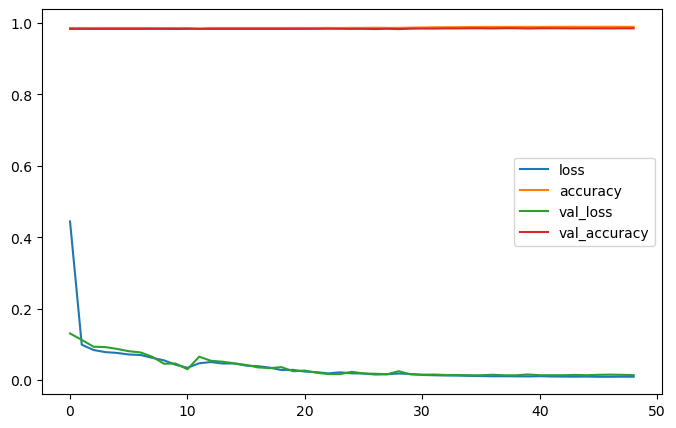

In [29]:
pd.DataFrame(results.history).plot(figsize=(8,5))
plt.show()

In [30]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0085 - accuracy: 0.9926


[0.00851423293352127, 0.9925842881202698]

In [31]:
pred = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [32]:
import tensorflow.keras.backend as K

In [33]:
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [34]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [35]:
print(dice_coef_loss(y_test,pred))
print(dice_coef(y_test,pred))

tf.Tensor(0.46011865, shape=(), dtype=float32)
tf.Tensor(0.53988135, shape=(), dtype=float32)


In [36]:
new_pred, new_Xtest, new_ytest = [], [], []

new_pred.append(pred[:4])
new_pred.append(pred[4:8])
new_pred.append(pred[8:])

new_Xtest.append(X_test[:4])
new_Xtest.append(X_test[4:8])
new_Xtest.append(X_test[8:])

new_ytest.append(y_test[:4])
new_ytest.append(y_test[4:8])
new_ytest.append(y_test[8:])

IndexError: index 3 is out of bounds for axis 0 with size 3

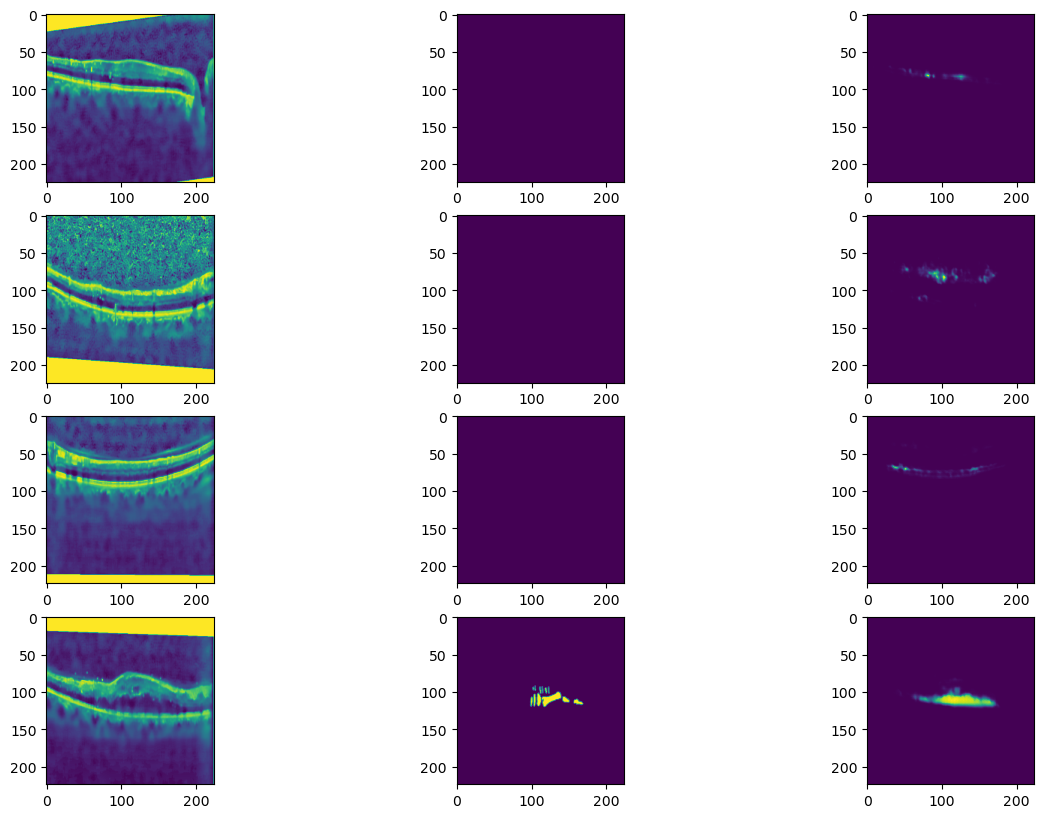

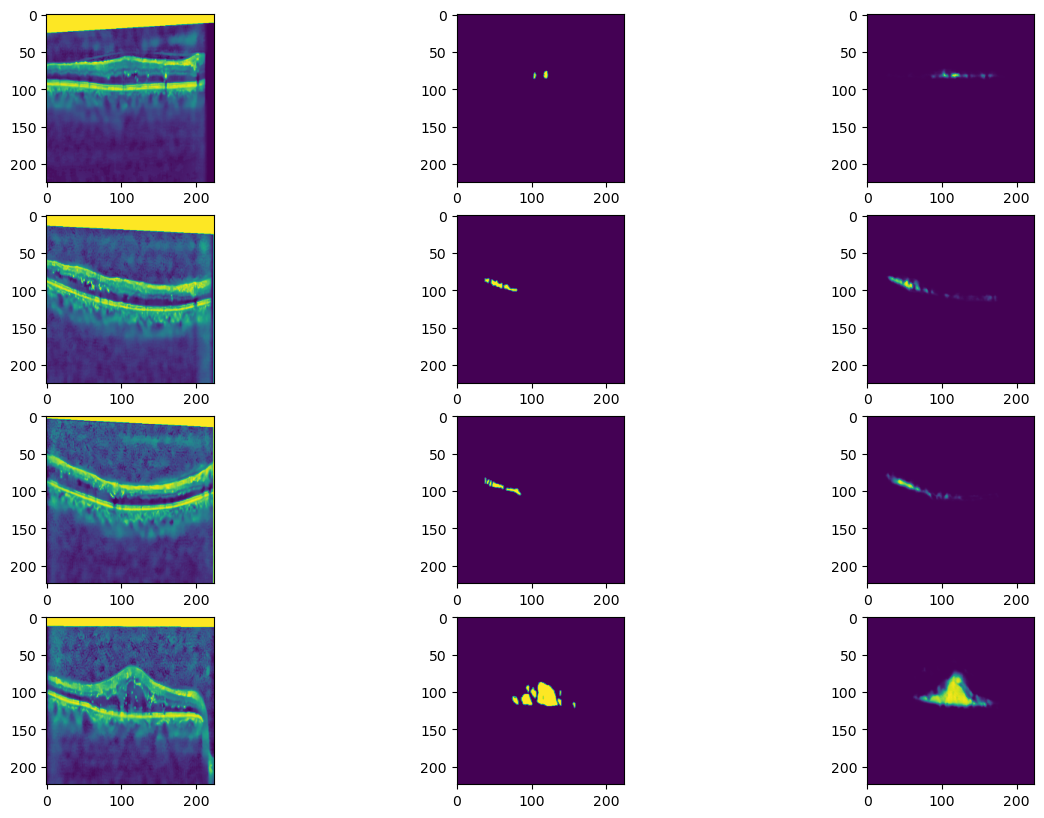

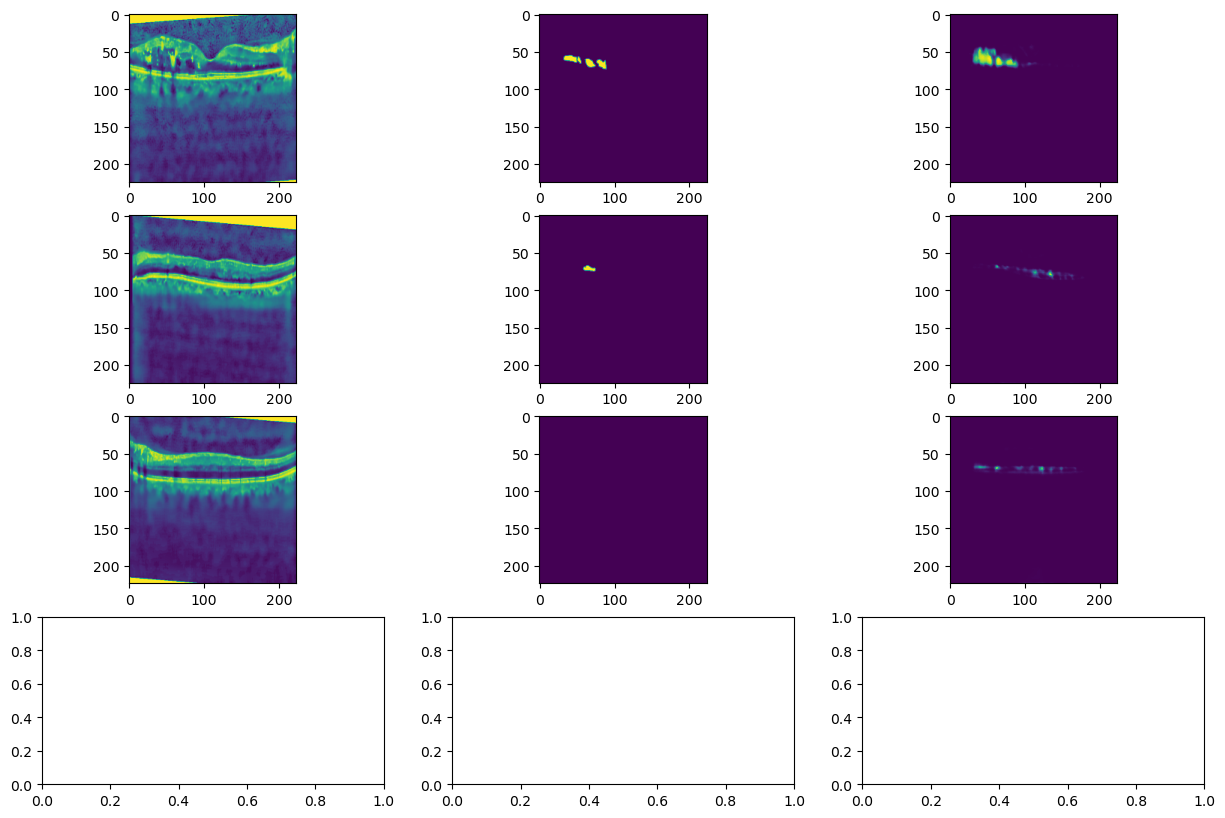

In [37]:
# prediction visualization
for i in range(len(new_Xtest)):
    nrows = 4
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 10))
    for j in range(nrows):
        axes[j][0].imshow(np.reshape(new_Xtest[i][j], (224, 224)))
        axes[j][1].imshow(np.reshape(new_ytest[i][j], (224, 224)))
        axes[j][2].imshow(np.reshape(new_pred[i][j], (224, 224)))

plt.show()

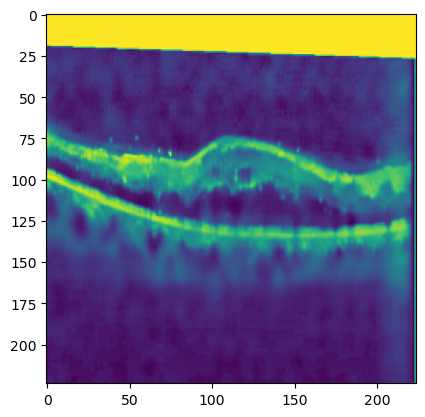

In [38]:
plt.imshow(X_test[3])

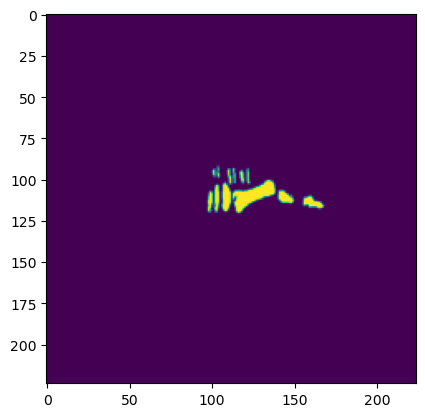

In [39]:
plt.imshow(y_test[3])

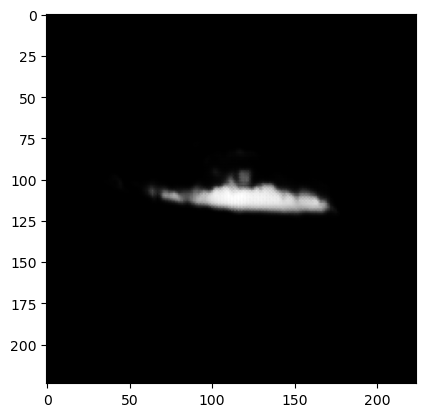

In [41]:
plt.imshow(pred[3],cmap='gray')